In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import pandas_ta as ta
import yfinance as yf

from datetime import datetime, timedelta

%matplotlib widget
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import notebook_utils

product_ids = ["ATOM-USD", "BTC-USD", "DOT-USD", "ETH-USD", "SOL-USD"]
# product_ids = ["BTC-USD", "ETH-USD"]

In [2]:
def get_df_fear_greed_index():
    print("Retrieving historical fear and greed index")
    fear_greed_index_response = requests.get("https://api.alternative.me/fng/?limit=" + str(24 * 365 * 5))
    df_fear_greed_index = pd.DataFrame(fear_greed_index_response.json()["data"])
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(int(x), unit="s", tz="UTC") for x in df_fear_greed_index.timestamp]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"value": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_history(product_id):
    print(f"Retrieving historical data for {product_id}")

    df_history = yf.Ticker(product_id).history(interval="1d", period="3y")[:-1]
    df_history.columns = map(str.lower, df_history.columns)

    timestamps = [pd.to_datetime(x, utc=True) for x in df_history.index.values]
    timestamps_date_range = pd.date_range(start=timestamps[0], end=timestamps[-1], freq="D")
    df_history = df_history.set_index(pd.DatetimeIndex(timestamps)).reindex(timestamps_date_range, method="ffill")

    df_history = df_history.join(df_fear_greed_index[["fear_greed_index"]])
    df_history["fear_greed_index"] = df_history.fear_greed_index.fillna(method="ffill").astype(float)

    def get_strategy_length(x):
        return x * 1

    for column in ["close", "fear_greed_index"]:
        for days in [7, 14, 30, 60, 90, 120]:
            periods = get_strategy_length(days)
            df_history[f"{column}_previous"] = df_history[column].shift(1)
            df_history[f"{column}_min_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).min()
            df_history[f"{column}_max_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).max()
            df_history[f"{column}_gradient_{days}"] = df_history[column].diff(periods=periods) / periods
            df_history[f"{column}_gradient_min_{days}"] = df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).min()
            df_history[f"{column}_gradient_max_{days}"] = df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).max()
    
    return df_history

df_fear_greed_index = get_df_fear_greed_index()
history_dfs = {}

for product_id in product_ids:
    history_dfs[product_id] = get_df_history(product_id)

Retrieving historical fear and greed index
Retrieving historical data for ATOM-USD
Retrieving historical data for BTC-USD
Retrieving historical data for DOT-USD
Retrieving historical data for ETH-USD
Retrieving historical data for SOL-USD


In [3]:
# total_products = len(history_dfs)
# fig, ax = plt.subplots(nrows=total_products, figsize=(10, 4 * total_products))
# days = 14

# for product_index, product_id in enumerate(product_ids):
#     ax_index = ax if total_products <= 1 else ax[product_index]
#     # history_dfs[product_id]["good_buy"] = history_dfs[product_id].fear_greed_index == history_dfs[product_id].fear_greed_index_min_30
#     df_history1 = history_dfs[product_id][["close", f"close_min_{days}", f"close_max_{days}"]].copy()
#     df_history2 = history_dfs[product_id][[f"close_gradient_{days}", f"close_gradient_min_{days}", f"close_gradient_max_{days}"]].copy()
#     df_history3 = history_dfs[product_id][["fear_greed_index", f"fear_greed_index_min_{days}", f"fear_greed_index_max_{days}"]].copy()
#     df_history4 = history_dfs[product_id][[f"fear_greed_index_gradient_{days}", f"fear_greed_index_gradient_min_{days}", f"fear_greed_index_gradient_max_{days}"]].copy()
    
#     df_history1_max = df_history1.to_numpy()[~np.isnan(df_history1.to_numpy())].max()
#     df_history2_max = df_history2.to_numpy()[~np.isnan(df_history2.to_numpy())].max()
#     df_history3_max = df_history3.to_numpy()[~np.isnan(df_history3.to_numpy())].max()
#     df_history4_max = df_history4.to_numpy()[~np.isnan(df_history4.to_numpy())].max()
    
#     for column in df_history1.columns:
#         df_history1[column] = df_history1[column] / df_history1_max
    
#     for column in df_history2.columns:
#         df_history2[column] = df_history2[column] / df_history2_max
    
#     for column in df_history3.columns:
#         df_history3[column] = df_history3[column] / df_history3_max
    
#     for column in df_history4.columns:
#         df_history4[column] = df_history4[column] / df_history4_max
    
#     df_history = df_history1.join(df_history2, how="outer").join(df_history3, how="outer").join(df_history4, how="outer")
#     df_history["buy_signal"] = (
#         (df_history.fear_greed_index > .4)
#         # & (df_history[f"close_gradient_{days}"] != df_history[f"close_gradient_min_{days}"])
#         & (df_history.fear_greed_index > df_history[f"fear_greed_index_min_{days}"])
#     ).replace({True: 1, False: 0})
    
#     df_history[[
#         "close",
#         "buy_signal",
#         "fear_greed_index",
#         # f"close_min_{days}", f"close_max_{days}",
#         # f"close_gradient_{days}", f"close_gradient_min_{days}", f"close_gradient_max_{days}",
#         # f"fear_greed_index_min_{days}", f"fear_greed_index_max_{days}",
#         # f"fear_greed_index_gradient_{days}", f"fear_greed_index_gradient_min_{days}", f"fear_greed_index_gradient_max_{days}"
#         # "buy_signal", "sell_signal"
#     ]].plot(ax=ax_index)
    
#     ax_index.set_title(product_id)

# plt.legend()
# plt.tight_layout()
# plt.show()

# # df_history = history_dfs[product_id]
# # display(df_history.corr().astype(str)[["period_max_close_pct_change"]])
# # display(df_history.describe())

Total fee percentage: 1.6%
Start money: $100
Min buy amount: $2
Max buy amount: $100
End money: $434.70
Pct earned: 334.696%
Total orders: 1649
Avg pct earned per order: 0.203%
Total volume: $9133.72
Total days: 1094.0
Avg 30 day volume: $250.47


,product_id,side,amount,coins,value,money,total_balance,fear_greed_index
timestamp,,,,,,,,
2020-12-03 00:00:00+00:00,ATOM-USD,buy,2.0,0.36046950734774813,5.503932952880859,98.0,99.968128,92.0
2020-12-03 00:00:00+00:00,ETH-USD,buy,2.0,0.00321707780442028,616.708740234375,96.0,99.93625599999999,92.0
2020-12-03 00:00:00+00:00,DOT-USD,buy,2.0,0.36670327468724345,5.410368919372559,94.0,99.90438399999998,92.0
2020-12-03 00:00:00+00:00,BTC-USD,buy,2.0,0.00010202927990274048,19445.3984375,92.0,99.87251199999997,92.0
2020-12-03 00:00:00+00:00,SOL-USD,buy,2.0,0.944595078501915,2.1003708839416504,90.0,99.84063999999996,92.0
...,...,...,...,...,...,...,...,...
2023-12-02 00:00:00+00:00,ATOM-USD,sell,68.94995505558164,7.20989357,9.640364646911621,150.36942268073972,434.6960235040167,74.0
2023-12-02 00:00:00+00:00,ETH-USD,sell,70.65913661552248,0.03288952,2165.7041015625,221.0285592962622,434.6960235040167,74.0
2023-12-02 00:00:00+00:00,BTC-USD,sell,70.31467415488126,0.00179555,39476.33203125,291.3432334511434,434.6960235040167,74.0


,product_id,side,total_orders
0,ATOM-USD,buy,303
1,ATOM-USD,sell,28
2,BTC-USD,buy,295
3,BTC-USD,sell,35
4,DOT-USD,buy,294
5,DOT-USD,sell,33
6,ETH-USD,buy,300
7,ETH-USD,sell,30
8,SOL-USD,buy,297
9,SOL-USD,sell,34


<Axes: xlabel='timestamp'>

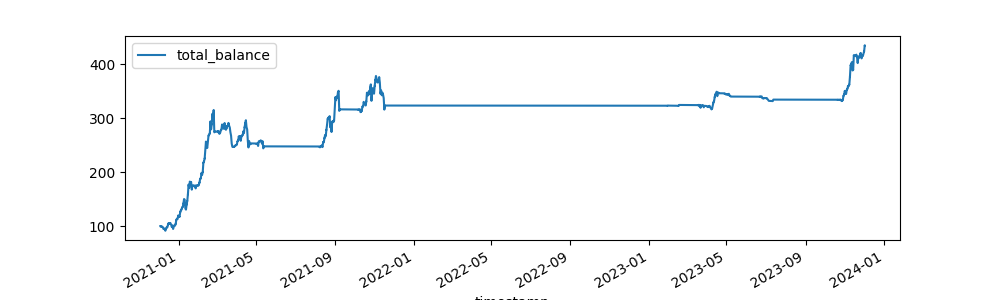

In [13]:
fee_pct = 1.6
p_keep = 1 - (fee_pct / 2 / 100)
print(f"Total fee percentage: {fee_pct}%")

coins = {}
coins_hold = {}
min_hold = 0
max_hold = 0

for product_id in product_ids:
    coins[product_id] = 0
    coins_hold[product_id] = 0

money = 100
start_money = money
print(f"Start money: ${start_money}")

min_buy_amount = 2
max_buy_amount = 100
print(f"Min buy amount: ${min_buy_amount}")
print(f"Max buy amount: ${max_buy_amount}")

total_orders = 0
total_volume = 0
orders = []

total_products = len(product_ids)

# feat_greed_schedule = [
#     {'threshold': 0, 'factor': 1, 'action': 'buy'},
#     {'threshold': 30, 'factor': 1, 'action': 'buy'},
#     # {'threshold': 40, 'factor': 0.25, 'action': 'buy'},
#     # {'threshold': 60, 'factor': 0.25, 'action': 'sell'},
#     {'threshold': 70, 'factor': 1, 'action': 'sell'},
#     {'threshold': 100, 'factor': 1, 'action': 'sell'}
# ]

for product_id in product_ids:
    history_dfs[product_id]["product_id"] = product_id

df_final = pd.concat([history_dfs[product_id] for product_id in product_ids]).sort_index()

for index, row in df_final.iterrows():
    product_id = row.product_id

    def get_total_balance():
        total_balance = money

        for coin_product_id in product_ids:
            df_final_product_period = df_final.loc[(df_final.index == index) & (df_final.product_id == coin_product_id)]

            if len(df_final_product_period) > 0:
                total_balance += coins[coin_product_id] * df_final_product_period.close.values[-1] * p_keep

        return total_balance

    def floor_value(x: float, precision: int):
        return np.true_divide(np.floor(x * 10**precision), 10**precision)

    condition_action = None
    condition_factor = None
    
    if (
        row.fear_greed_index > 60
        # and row.fear_greed_index > row.fear_greed_index_min_30
        
        # and row.fear_greed_index < 90
        # row.fear_greed_index == row.fear_greed_index_min_30
        # money > len(product_ids)

        # and coins_hold[product_id] <= 7
        and (coins[product_id] * row.close) < 1000
        and money >= min_buy_amount

        # and row[f"close_gradient_{days}"] > 0
        # and row[f"fear_greed_index_gradient_{days}"] > 0
        
        and pd.to_datetime(index, utc=True) != pd.to_datetime(df_final.index.values[-1], utc=True)
    ):
        condition_action = "buy"
    else:
        condition_action = "sell"

    if condition_action == "buy":
        # condition_factor = (100 - row.fear_greed_index) / 100
        # # # condition_factor = 1
        # buy_amount = floor_value(money / len(product_ids) * condition_factor, 2)
        # buy_amount = money / len(product_ids)
        buy_amount = floor_value(money / len(product_ids) / 10, 2)
        buy_amount = buy_amount if buy_amount >= min_buy_amount else min_buy_amount
        buy_amount = buy_amount if buy_amount <= max_buy_amount else max_buy_amount

        if money >= buy_amount and buy_amount > 0:
            money -= buy_amount
            buy_coins = buy_amount / row.close * p_keep
            coins[product_id] += buy_coins
            total_orders += 1
            total_volume += buy_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "buy",
                    "amount": buy_amount,
                    "coins": buy_coins,
                    "value": row.close,
                    "money": money,
                    "total_balance": get_total_balance(),
                    "fear_greed_index": row.fear_greed_index,
                    # "fear_greed_index_min_30": row.fear_greed_index_min_30
                }
            )
    elif condition_action == "sell":
        # condition_factor = row.fear_greed_index / 100
        condition_factor = 1
        sell_coins = floor_value(coins[product_id] * condition_factor, 8)
        coins[product_id] = coins[product_id] - sell_coins
        coins_hold[product_id] = 0
        sell_amount = sell_coins * row.close * p_keep
    
        if sell_amount > 0:
            total_orders += 1
            total_volume += sell_amount
            money += sell_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "sell",
                    "amount": sell_amount,
                    "coins": sell_coins,
                    "value": row.close,
                    "money": money,
                    "total_balance": get_total_balance(),
                    "fear_greed_index": row.fear_greed_index,
                    # "fear_greed_index_min_30": row.fear_greed_index_min_30
                }
            )
    
    coins_hold[product_id] += 1

money += sum(
    [
        (coins[product_id] * df_final.loc[df_final.product_id == product_id].close.values[-1] * p_keep)
        for product_id in product_ids
    ]
)

print(f"End money: ${money:.2f}")
pct_earned = (money - start_money)/start_money*100
print(f"Pct earned: {pct_earned:.3f}%")
days = (df_final.index.values[-1] - df_final.index.values[0]).astype("timedelta64[D]") / np.timedelta64(1, "D")
print(f"Total orders: {total_orders}")
print(f"Avg pct earned per order: {pct_earned / total_orders:.3f}%")
print(f"Total volume: ${total_volume:.2f}")
print(f"Total days: {days}")
print(f"Avg 30 day volume: ${(total_volume / days * 30):.2f}")

df_orders = pd.DataFrame(orders)
df_orders.set_index("timestamp", inplace=True)
display(df_orders.astype(str))

orders_info = []
for product_id in product_ids:
    for side in ["buy", "sell"]:
        df_orders_product_side = df_orders.loc[(df_orders.product_id == product_id) & (df_orders.side == side)]
        orders_info.append({
            "product_id": product_id,
            "side": side,
            "total_orders": len(df_orders_product_side),
            # "avg_value": df_orders_product_side.value.sum() / len(df_orders_product_side)
        })

df_orders_info = pd.DataFrame(orders_info)
display(df_orders_info)

df_orders[["total_balance"]].plot(figsize=(10, 3))
# df_orders_scaled = df_orders[["total_balance", "fear_greed_index", "fear_greed_index_min_30"]]
# df_orders_scaled = pd.DataFrame(scaler.fit_transform(df_orders_scaled.values), index=df_orders_scaled.index, columns=df_orders_scaled.columns).plot(figsize=(10, 3))

In [14]:
df_orders[100:200]

,product_id,side,amount,coins,value,money,total_balance,fear_greed_index
timestamp,,,,,,,,
2020-12-23 00:00:00+00:00,ETH-USD,buy,2.000000,0.003399,583.714600,35.030298,94.929711,93.0
2020-12-23 00:00:00+00:00,SOL-USD,buy,2.000000,1.645528,1.205692,33.030298,94.897839,93.0
2020-12-23 00:00:00+00:00,ATOM-USD,buy,2.000000,0.453206,4.377698,31.030298,94.865967,93.0
2020-12-23 00:00:00+00:00,BTC-USD,buy,2.000000,0.000085,23241.345703,29.030298,94.834095,93.0
2020-12-23 00:00:00+00:00,DOT-USD,buy,2.000000,0.421177,4.710613,27.030298,94.802223,93.0
2020-12-24 00:00:00+00:00,BTC-USD,buy,2.000000,0.000084,23735.949219,25.030298,99.768501,86.0
2020-12-24 00:00:00+00:00,DOT-USD,buy,2.000000,0.386834,5.128821,23.030298,99.736629,86.0
2020-12-24 00:00:00+00:00,SOL-USD,buy,2.000000,1.456245,1.362408,21.030298,99.704757,86.0
2020-12-24 00:00:00+00:00,ATOM-USD,buy,2.000000,0.400888,4.949012,19.030298,99.672885,86.0


In [5]:
display(df_orders.loc[df_orders.side == "buy"].describe())
display(df_orders.loc[df_orders.side == "sell"].describe())
# df_orders.loc[(df_orders.index >= pd.Timestamp("2022-12-01", tz="UTC")) & (df_orders.index <= pd.Timestamp("2023-06-01", tz="UTC"))].tail(100)

,amount,coins,value,money,total_balance,fear_greed_index
count,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000
mean,2.181990,0.116834,9574.913846,107.165589,245.554715,73.208548
std,1.873583,0.235978,18763.047976,91.804399,94.692914,8.518156
min,0.200000,0.000003,1.799275,9.848121,99.894690,61.000000
25%,0.740000,0.000276,18.822123,36.580000,167.058137,68.000000
50%,1.530000,0.015271,42.457310,75.039165,233.003598,72.000000
75%,3.020000,0.104576,3226.083984,148.132272,330.301343,76.000000
max,8.310000,1.612329,67566.828125,407.394326,424.684379,95.000000


,amount,coins,value,money,total_balance,fear_greed_index
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,23.888827,1.148871,7853.696793,230.141295,278.863189,57.760870
std,22.825213,2.066523,15372.787137,100.835963,93.069574,10.242715
min,1.688090,0.000037,3.613398,35.082331,105.699236,31.000000
25%,6.853973,0.003798,11.270308,127.697700,171.345750,53.250000
50%,15.751788,0.444886,30.664149,275.616801,315.287450,56.000000
75%,27.403609,1.364137,2093.505127,314.449987,335.512243,60.000000
max,124.698854,13.007172,60368.011719,435.698080,435.698271,94.000000
